In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [37]:
customers = pd.read_excel("E-commerce_data.xlsx",sheet_name="customers")
genders = pd.read_excel("E-commerce_data.xlsx",sheet_name="genders")
cities = pd.read_excel("E-commerce_data.xlsx",sheet_name="cities")
transactions = pd.read_excel("E-commerce_data.xlsx",sheet_name="transactions")
branches = pd.read_excel("E-commerce_data.xlsx",sheet_name="branches")
merchants = pd.read_excel("E-commerce_data.xlsx",sheet_name="merchants")

In [38]:
customers.isnull().sum()

customer_id    0
join_date      0
city_id        0
gender_id      0
dtype: int64

In [39]:
genders.isnull().sum()

gender_id      0
gender_name    0
dtype: int64

In [40]:
cities.isnull().sum()

city_id      0
city_name    0
dtype: int64

In [41]:
transactions.isnull().sum()

transaction_id           0
customer_id              0
transaction_date         0
transaction_status       0
coupon_name              0
burn_date             2484
branch_id                0
dtype: int64

In [42]:
transactions.drop(["burn_date"], axis=1, inplace=True)    # Removing column with null values

In [43]:
transactions.isnull().sum()

transaction_id        0
customer_id           0
transaction_date      0
transaction_status    0
coupon_name           0
branch_id             0
dtype: int64

In [44]:
branches.isnull().sum()

branch_id      0
merchant_id    0
dtype: int64

In [45]:
merchants.isnull().sum()

merchant_id      0
merchant_name    0
dtype: int64

In [46]:
merged_df = pd.merge(customers, transactions, on='customer_id', how='inner')

In [47]:
merged_df.head()

,customer_id,join_date,city_id,gender_id,transaction_id,transaction_date,transaction_status,coupon_name,branch_id
0,1,2022-01-08,7,1,178,2022-07-30,subscribed,SrP-866,8
1,1,2022-01-08,7,1,257,2022-09-19,burned,krI-075,1
2,1,2022-01-08,7,1,1652,2022-06-09,burned,quk-137,6
3,1,2022-01-08,7,1,1929,2022-07-30,burned,QiG-754,8
4,1,2022-01-08,7,1,2352,2023-03-24,subscribed,OtC-985,4


In [48]:
# Calculate the number of transactions per customer
transaction_counts = merged_df.groupby('customer_id')['transaction_id'].count().reset_index()
transaction_counts.columns = ['customer_id', 'transaction_count']

In [49]:
transaction_counts

,customer_id,transaction_count
0,1,7
1,2,3
2,3,5
3,4,1
4,5,4
...,...,...
984,996,3
985,997,3
986,998,4
987,999,4


In [50]:
# Calculate coupon usage frequency (burned vs subscribed)
coupon_usage = merged_df.groupby('customer_id')['transaction_status'].apply(
    lambda x: (x == 'burned').mean()).reset_index()
coupon_usage.columns = ['customer_id', 'burn_rate']
coupon_usage.tail()

,customer_id,burn_rate
984,996,0.000000
985,997,0.333333
986,998,0.750000
987,999,1.000000
988,1000,0.500000


In [51]:
# Merge these engineered features back to the dataset
processed_df = pd.merge(merged_df, transaction_counts, on='customer_id', how='left')
processed_df = pd.merge(processed_df, coupon_usage, on='customer_id', how='left')

In [52]:
# Step 4: Scaling Numerical Features
from sklearn.preprocessing import StandardScaler

# Select numerical features to scale
numerical_features = ['transaction_count', 'burn_rate']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
processed_df[numerical_features] = scaler.fit_transform(processed_df[numerical_features])

# Display the preprocessed data
processed_df.head()

,customer_id,join_date,city_id,gender_id,transaction_id,transaction_date,transaction_status,coupon_name,branch_id,transaction_count,burn_rate
0,1,2022-01-08,7,1,178,2022-07-30,subscribed,SrP-866,8,0.407599,-0.340281
1,1,2022-01-08,7,1,257,2022-09-19,burned,krI-075,1,0.407599,-0.340281
2,1,2022-01-08,7,1,1652,2022-06-09,burned,quk-137,6,0.407599,-0.340281
3,1,2022-01-08,7,1,1929,2022-07-30,burned,QiG-754,8,0.407599,-0.340281
4,1,2022-01-08,7,1,2352,2023-03-24,subscribed,OtC-985,4,0.407599,-0.340281


In [53]:
selected_features = ['transaction_count', 'burn_rate']  # Transactional features

In [54]:
# The final dataset for clustering
clustered_data = processed_df[selected_features]

In [55]:
clustered_data.head()

,transaction_count,burn_rate
0,0.407599,-0.340281
1,0.407599,-0.340281
2,0.407599,-0.340281
3,0.407599,-0.340281
4,0.407599,-0.340281


In [56]:
inertia = []
silhouette_scores = []
cluster_labels_list = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)    # Initialize K-Means with k clusters
       
    cluster_labels = kmeans.fit_predict(clustered_data)    # Fit the model and predict cluster labels for each customer
    
    cluster_labels_list.append(cluster_labels)    # Store the labels for each number of clusters
    
    inertia.append(kmeans.inertia_)    # Calculate inertia (sum of squared distances from each point to its assigned cluster center)
    
    silhouette_avg = silhouette_score(clustered_data, cluster_labels)    # Calculate the silhouette score
    silhouette_scores.append(silhouette_avg)

In [57]:
silhouette_avg

0.4353062847550859

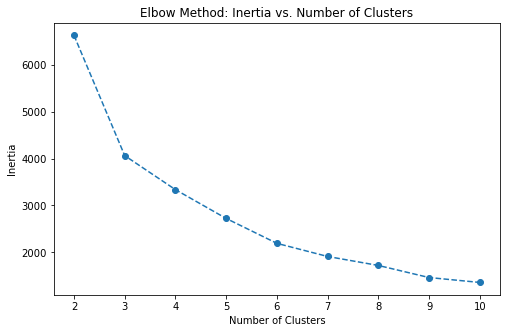

In [58]:
# Step 3: Plot the elbow curve for inertia
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

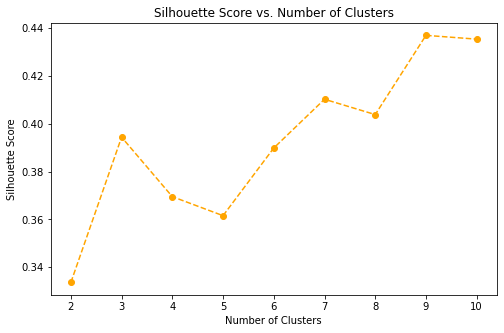

In [59]:
# Step 4: Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [60]:
optimal_k = 6  # based on the previous evaluation

In [61]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(clustered_data)

In [62]:
processed_df['cluster'] = cluster_labels

In [63]:
cluster_analysis = processed_df.groupby('cluster').mean()

In [64]:
cluster_analysis.head()

,customer_id,city_id,gender_id,transaction_id,branch_id,transaction_count,burn_rate
cluster,,,,,,,
0,489.463731,11.000000,1.533679,2525.520725,5.391192,-0.927795,0.274817
1,480.404389,9.844828,1.521944,2528.691223,5.589342,-0.913342,-1.529712
2,530.465190,9.180380,1.424051,2515.506329,5.316456,1.731297,-0.238245
3,522.674419,10.014156,1.436805,2519.712841,5.689585,0.558554,0.656218
4,503.866455,9.930048,1.510334,2520.454690,5.689984,-0.798820,1.583826


In [65]:
print(cluster_analysis)

         customer_id    city_id  gender_id  transaction_id  branch_id  \
cluster                                                                 
0         489.463731  11.000000   1.533679     2525.520725   5.391192   
1         480.404389   9.844828   1.521944     2528.691223   5.589342   
2         530.465190   9.180380   1.424051     2515.506329   5.316456   
3         522.674419  10.014156   1.436805     2519.712841   5.689585   
4         503.866455   9.930048   1.510334     2520.454690   5.689984   
5         518.121642  10.249254   1.497761     2442.038060   5.488806   

         transaction_count  burn_rate  
cluster                                
0                -0.927795   0.274817  
1                -0.913342  -1.529712  
2                 1.731297  -0.238245  
3                 0.558554   0.656218  
4                -0.798820   1.583826  
5                 0.115551  -0.545417  


In [66]:
cluster_size = processed_df['cluster'].value_counts()
print("Cluster Sizes:\n", cluster_size)

Cluster Sizes:
 5    1340
3     989
0     772
1     638
2     632
4     629
Name: cluster, dtype: int64


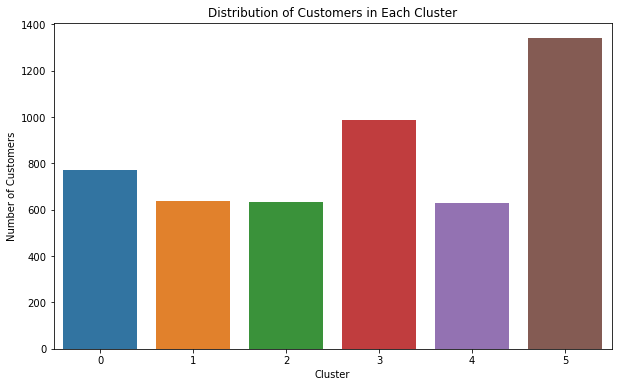

In [67]:
# Step 6: Visualize the cluster distributions (Optional)
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=processed_df)
plt.title('Distribution of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()